In [1]:
!pip install datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch

In [4]:
# Load NepBERTa Model
from transformers import AutoTokenizer, AutoModelForSequenceClassification , Trainer, TrainingArguments

tokenizer = AutoTokenizer.from_pretrained("NepBERTa/NepBERTa")
model = AutoModelForSequenceClassification .from_pretrained("NepBERTa/NepBERTa", from_tf=True,num_labels=3)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [4]:
# Load nepaliBERT Model
from transformers import AutoTokenizer, AutoModelForSequenceClassification , Trainer, TrainingArguments

tokenizer = AutoTokenizer.from_pretrained("Shushant/nepaliBERT")
model = AutoModelForSequenceClassification .from_pretrained("Shushant/nepaliBERT",num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/589 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/529k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Shushant/nepaliBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
df_train = pd.read_csv('/content/drive/MyDrive/Sentiment/train_clean.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Sentiment/test_clean.csv')

In [35]:
df = pd.DataFrame.merge(df_train,df_test,how='outer')

In [36]:
df['text'].apply(len).describe()

,text
count,7974.000000
mean,75.458866
std,82.996088
min,2.000000
25%,31.000000
50%,56.000000
75%,96.000000
max,2855.000000


In [37]:
df['text'].apply(len).quantile(0.98)

259.0

In [38]:
X = list(df['text'])
y = list(df['label'])

In [39]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0,stratify=y)
X_test,X_eval,y_test,y_eval = train_test_split(X_test,y_test,test_size=0.3,random_state=0,stratify=y_test)

In [40]:
def plot_occ(ax,data):
  ax.set_xlabel('Integers')
  ax.set_ylabel('Occurrences')
  sns.histplot(data, bins=3, kde=False, discrete=True,ax=ax)

Text(0.5, 0.98, 'Labels across various splits (Train, Test, Eval)')

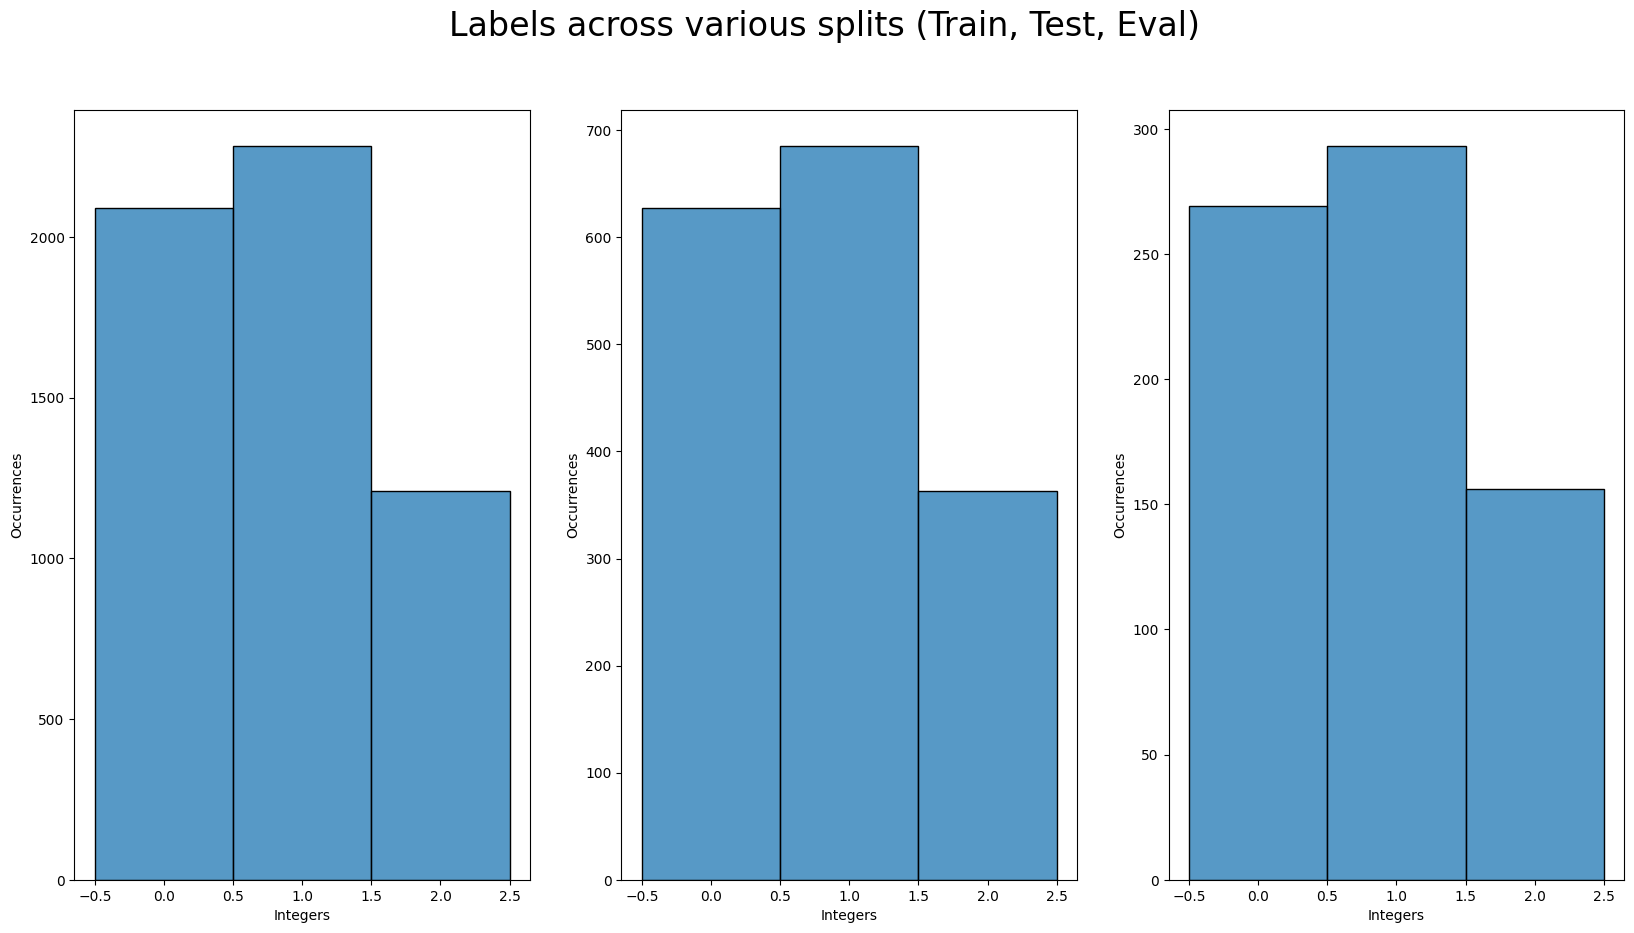

In [41]:
fig,axes = plt.subplots(1,3,figsize=(20,10))
plot_occ(axes[0],y_train)
plot_occ(axes[1],y_test)
plot_occ(axes[2],y_eval)
plt.suptitle("Labels across various splits (Train, Test, Eval)", fontsize=24)


In [42]:
# Verify all the rows are of type str
for idx,text in enumerate(X):
  if not isinstance(text,str):
    print(text)
    print(idx)

In [43]:
pad_length = 256

In [44]:
# Convert text into tokens using the tokenizer from NepBERTa
train_encodings = tokenizer(X_train,truncation=True,padding=True,max_length=pad_length)
eval_encodings = tokenizer(X_eval,truncation=True,padding=True,max_length=pad_length)
test_encodings = tokenizer(X_test,truncation=True,padding=True,max_length=pad_length)

In [45]:
# Convert the dataset into a dict to convert into Dataset object from huggingface
train_data = {
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": y_train
}
eval_data = {
    "input_ids": eval_encodings["input_ids"],
    "attention_mask": eval_encodings["attention_mask"],
    "labels": y_eval
}
test_data = {
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": y_test
}

In [46]:
from datasets import Dataset
# Convert the dict into Dataset object
train_dataset = Dataset.from_dict(train_data)
eval_dataset = Dataset.from_dict(eval_data)
test_dataset = Dataset.from_dict(test_data)

In [47]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 5581
})

In [48]:
print(np.array(train_dataset[0]['input_ids']).shape)

(256,)


In [49]:
training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs=4,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size=64,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50
)

In [50]:
# import os
# # Unset the WANDB_API_KEY
# os.environ["WANDB_MODE"] = "disabled"
import wandb

# Set API key
wandb.login(key="c65fef72e0240cc4cc1477580c8142ecbef16bca")

wandb.init(project="SentimentAnalysisUsingNepBERTa")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
test/accuracy,▁
test/loss,▁
test/runtime,▁
test/samples_per_second,▁
test/steps_per_second,▁
train/epoch,▁▂▃▄▆▇███


In [51]:
from sklearn.metrics import accuracy_score

def compute_metrics(p):
    preds, labels = p
    preds = preds.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

In [52]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

Step,Training Loss
50,0.304400
100,0.327400
150,0.239700
200,0.191600
250,0.183200
300,0.152400
350,0.154300


TrainOutput(global_step=352, training_loss=0.22141277620738203, metrics={'train_runtime': 863.4485, 'train_samples_per_second': 25.854, 'train_steps_per_second': 0.408, 'total_flos': 2936871968679936.0, 'train_loss': 0.22141277620738203, 'epoch': 4.0})

In [53]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.8517663478851318,
 'eval_accuracy': 0.7797014925373135,
 'eval_runtime': 22.2951,
 'eval_samples_per_second': 75.129,
 'eval_steps_per_second': 1.211,
 'epoch': 4.0}

In [54]:
output = trainer.predict(test_dataset)

In [55]:
preds = output[0]

In [56]:
out_preds =[out.argmax() for out in preds]

In [57]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,out_preds)
cm

array([[464,  67,  96],
       [ 60, 598,  27],
       [ 71,  48, 244]])

In [58]:
cm.diagonal().sum() / cm.sum()

0.7797014925373135

In [59]:
from sklearn.metrics import classification_report
print(classification_report(out_preds, y_test))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       595
           1       0.87      0.84      0.86       713
           2       0.67      0.66      0.67       367

    accuracy                           0.78      1675
   macro avg       0.76      0.76      0.76      1675
weighted avg       0.78      0.78      0.78      1675



In [60]:
tokenizer.name_or_path

'Shushant/nepaliBERT'

In [61]:
trainer.save_model('sentiment_model_best')